Preamble: <br>
Author: Stephen Brownsey  <br>
Python version: 3.10.5 64-bit  <br>


The problem is to predict which cases will lapse and is broken down into three sections:
1. Data exploration: What are the most interesting features of the data set? What have you considered and why have you made the decisions you have done?
2. Modelling: What process did you follow when modelling retention? How have you designed your model and what did you account for
3. What are your conclusions and what else would’ve been useful to know?


In [1]:
#Library loading section
import pandas as pd
import numpy as np
import sklearn as skl
import sweetviz as sv
from tqdm import tqdm
from utils import get_missing_column_values, pickle_model, import_pickled_model
from datetime import datetime, date
from dateutil.relativedelta import relativedelta
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, train_test_split
from sklearn.metrics import f1_score, ConfusionMatrixDisplay, silhouette_score
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegressionCV
from sklearn import preprocessing
import xgboost as xgb
import scipy.stats as st
import pickle
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
import shap

c:\Users\steph\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data = pd.read_csv("data/home_insurance.csv").drop(columns = ["i", "Police"], errors = "ignore") #Dropping the two identifier columns i is the index and police is the police number

In [3]:
#First look
print("Number of Categorical Features: ", len([x for x in data.select_dtypes(include=['object'])]))
print("Number of Numeric Features:", len([x for x in data.select_dtypes(exclude=['object'])]))


Number of Categorical Features:  41
Number of Numeric Features: 23


In [4]:
#Sweetviz is a very good EDA library that shows you information about all the columns in the dataframe, takes a few minutes to run, so just open raw_data.html from repo to see this output
#my_report = sv.analyze(data)
#my_report.show_html("raw_data.html")



This sweetviz report quickly tells us a few things about the dataset:
1. There are 67115 cases where there is a missing policy status, since this is our dependent variable, rows which are missing here should be removed. This number of 67115 is also present in a lot of the other variables as such it backs up this thought. There are also 16 Unknown policies, since this is such a low number we can afford to remove them as well
2. There are some irrelevant columns which only have one option such as PAYMENT_FREQUENCY and CAMPAIGN_DESC which is all missing.
3. There are a number of variables that are majority missing, more analysis will be undertaken for these but it is expected that most will be dropped before modelling.
4. There are a number of date variables, which should be put through feature engineering before we add them to our model
5. Some columns are very heavily skewed so to consider whether these should be considered for the model or not
6. There are some numerical columns such as SUM_INSURED_CONTENTS/SUM_INSURED_BUILDING that are more ordinal than continuous so should be encoded as such
7. There are very strong associations between a lot of the columns, particularly around pre renewal and post renewal columns which highlights perhaps they should be combined. As well as sum assured and premium columns which are very strongly linked. The dataset should go through a rigourous feature selection process before being used for modelling to iron out as much of these correlations as possible
8. There are some outliers which will need looking at in more detail

In [5]:
# Looking into point 1:
# Quick look into the Null Policy status rows to see if it contains anything useful
data[pd.isnull(data.POL_STATUS)].describe()


,RISK_RATED_AREA_B,SUM_INSURED_BUILDINGS,NCD_GRANTED_YEARS_B,RISK_RATED_AREA_C,SUM_INSURED_CONTENTS,NCD_GRANTED_YEARS_C,SPEC_SUM_INSURED,SPEC_ITEM_PREM,UNSPEC_HRP_PREM,BEDROOMS,...,MAX_DAYS_UNOCC,OWNERSHIP_TYPE,PAYING_GUESTS,PROP_TYPE,YEARBUILT,CAMPAIGN_DESC,PAYMENT_FREQUENCY,MTA_FAP,MTA_APRP,LAST_ANN_PREM_GROSS
count,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,340.000000,340.000000,1018.000000
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,223.310382,96.815647,208.483094
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,109.129222,135.085932,101.016586
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.910000,-78.590000,-1.910000
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,152.257500,0.000000,141.207500
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,198.575000,0.000000,187.760000
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,278.680000,194.570000,260.105000
max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,650.380000,600.820000,721.960000


In [6]:
#Now update the data view to remove Unknown and Null policies
data = data[ (~pd.isnull(data.POL_STATUS)) & (data.POL_STATUS != "Unknown")]
#my_report = sv.analyze(data)
#my_report.show_html("full_dataset.html")


#### Point 2/Point 3: <br>
From point 2 it can be seen that PAYMENT_FREQUENCY AND CAMPAIGN_DESC should be dropped from the analysis as they are irrelevant.
Looking into Point 3, to start with will drop P1_PT_EMP_STATUS and CLERICAL as very high percentage missing and 


In [7]:
# Looking at point 2:
data.drop(["PAYMENT_FREQUENCY", "CAMPAIGN_DESC"],axis = 1, inplace=True)
missing_info = get_missing_column_values(df = data)
missing_info





,column,missing_count,missing_percentage
1,P1_PT_EMP_STATUS,187223,99.06
2,CLERICAL,186061,98.44
7,MTA_DATE,162578,86.02
5,MTA_FAP,133630,70.70
6,MTA_APRP,133630,70.70
0,QUOTE_DATE,109868,58.13
3,RISK_RATED_AREA_B,48140,25.47
4,RISK_RATED_AREA_C,8731,4.62


In [8]:
def index_insight(column, data = data):
    nulled = data[(pd.isnull(data[column]))]["POL_STATUS"]
    contained = data[ (~pd.isnull(data[column]))]["POL_STATUS"] 
    total_null = len(nulled)
    total_contained = len(contained)
    nulled = pd.DataFrame(nulled.value_counts() ).rename(columns= {"POL_STATUS": "nulled"})
    contained = pd.DataFrame(contained.value_counts()).rename(columns= {"POL_STATUS": "contained"})
    df = pd.concat([nulled, contained], axis = 1).reset_index().rename(columns = {"index":"POL_STATUS"})
    df["index"] = round( (df.contained/total_contained)/(df.nulled/total_null), 3)
    df["column"] = column
    return df[["column", "POL_STATUS", "contained", "nulled", "index"]]

indexes = index_insight('P1_PT_EMP_STATUS')
iterate_cols = missing_info.column.unique().tolist()
iterate_cols.remove('P1_PT_EMP_STATUS')

for column in iterate_cols:
    temp = index_insight(column)
    indexes = pd.concat([indexes, temp])
indexes


#Switching P1_PT_EMP_STATUS to be a second job indicator
data["second_job"] = np.select([
    (pd.isnull(data["P1_PT_EMP_STATUS"])),
    (~pd.isnull(data["P1_PT_EMP_STATUS"]))
], ["N", "Y"] )
data.drop(["P1_PT_EMP_STATUS", "CLERICAL"], axis = 1, inplace=True)



In [9]:
# Looking at NAs in MTA_FAP and MTA_APRP: These columns are the bonusup to date of adjustment and the adjustment of the premium
# going to replace all the NaNs with 0 as if there was no adjustment then no midterm change occured
data[["MTA_FAP", "MTA_APRP"]] = data[["MTA_FAP", "MTA_APRP"]].fillna(0)

In [10]:
# Looking at the RISK_Rated columns, we note that a higher number can be associated with a higher risk
# 0 is the most common result for both of them and it would be a reasonable assumption that if it was null then there is a low risk so again just going to fillnas with 0
# Potentially could build another model to predict the number , but feels overkill
data[["RISK_RATED_AREA_B", "RISK_RATED_AREA_C"]] = data[["RISK_RATED_AREA_B", "RISK_RATED_AREA_C"]].fillna(0)

#### Point 4: <br>
There are 4 columns which are dates - these are encoded as object columns in the df, so convert them to datetime and perform feature engineering on them.
Columns are: QUOTE_DATE, COVER_START, P1_DOB, MTA_DATE <br>
Feature engineering of date columns:<br>
MTA_DATE will be dropped, this is due both the large % of missing data and the three other MTA related columns <br>
P1_DOB will be changed to age at policy start <br>
For COVER_START day and month will be extracted as could provide some insight if there are weekly/day variations <br>
QUOTE_DATE has lots of nulls, so we'll change it to a categorical column of "Unknown", "Same as Cover Start", "within 2 week of cover start" and "great than 2 weeks of cover start". There could be an underlying reason for the Nulls such as that policy came in via an agent so was always on the same day as start date, but without deeper knowledge of the dataset impossible for know so just encoding to "Unknown" for now. There were some cases that QUOTE_DATE is after COVER_START which looks wrong.

In [11]:
data.drop("MTA_DATE", axis = 1, inplace=True)
data[["QUOTE_DATE", "COVER_START", "P1_DOB"]] = data[["QUOTE_DATE", "COVER_START", "P1_DOB"]].apply(lambda _: pd.to_datetime(_, infer_datetime_format=True ,errors='coerce'))

In [12]:
data
data["quote_variation"] = (data.COVER_START - data.QUOTE_DATE)/np.timedelta64(1, "D")
print("Number of Cases with Quote Date After Start Date: " + str(len(data["quote_variation"][data.quote_variation < 0])))

def quote_date_updator(row):
    if(pd.isnull(row)):
        return "unknown"
    elif(abs(row) <= 14):
        return "less_than_14_days"
    elif(abs(row) > 14):
        return "greater_than_14_days"


data["quote_variation"] = data.quote_variation.apply(quote_date_updator)#.value_counts()
data.drop("QUOTE_DATE", axis = 1, inplace=True)



Number of Cases with Quote Date After Start Date: 475


In [13]:
#Calculating user age
data['Age'] = (data['COVER_START'] - data['P1_DOB']).astype('timedelta64[Y]').astype('int')
data.drop("P1_DOB", axis = 1, inplace=True)
#Switching Quote and Cover Start days into Day of week and month of year
def date_feature_engineerer(data = data, column = "COVER_START", prefix = "cover_start"):
    column1 = prefix + "_day_of_week"
    column2 = prefix + "_month"
    data[column1] = data[column].dt.day_name()
    data[column2] = data[column].dt.month_name()
    data.drop(column, axis = 1, inplace=True)

date_feature_engineerer()


#### Point 5:

Going to use an XGB algorithm to start with and this handles skewed data well so no need to overly worry about it.


#### Point 6:
Encoding the ordinal float columns instead of continuous

In [14]:
def update_sum_insured_contents(row):
    if row == 0:
        return 0
    elif row == 50000:
        return 1
    elif row == 55000:
        return 2
    elif row == 60000:
        return 3
    elif row == 65000:
        return 4
    elif row == 70000:
        return 5
    elif row == 75000:
        return 6
    elif row == 80000:
        return 7
    elif row == 85000:
        return 8
    elif row == 90000:
        return 9
    else:
        return 10

data["SUM_INSURED_CONTENTS"] = data["SUM_INSURED_CONTENTS"].apply(update_sum_insured_contents)

In [15]:
#Updating unoccupied days to a binary variable - this is due to low counts for other options (e.g 60 only appears once)
def update_unoccupied_days(row):
    if row == 0:
        return "N"
    else:
        return "Y"

data["MAX_DAYS_UNOCC"] = data["MAX_DAYS_UNOCC"].apply(update_sum_insured_contents)
#Updating Paying Guests
data["PAYING_GUESTS"] = np.where(data["PAYING_GUESTS"] == 0, "N", "Y")

In [16]:
data["SUM_INSURED_BUILDINGS"] = data["SUM_INSURED_BUILDINGS"].replace({0.0:"N", 1000000.0:"Y"})


#### Points 7
Looking at the strong associations in the data, going to combine the pre and post columns into one column <br>
Going to remove the premium columns, these are driving by a combination of the other columns, particularly sum assured

In [17]:
def pre_post_combiner(data = data, column = "LEGAL_ADDON"):
    """Combine pre and post columns

    Args:
        data (pd.DataFrame, optional): Dataframe to apply combining to. Defaults to data.
        column (str, optional): Column to apply combining to. Defaults to "LEGAL_ADDON".
    """
    pre = column + "_ADDON_PRE_REN"
    post = column + "_ADDON_POST_REN"
    data[column] = data[pre] + data[post]
    data.drop([pre, post], axis = 1, inplace=True)

cols = ["LEGAL", "HOME_EM", "GARDEN", "KEYCARE", "HP1", "HP2", "HP3"]
for col in cols:
    pre_post_combiner(column = col)

In [18]:
#Dropping the Premium columns, but keeping last years premium
data.drop(list(data.filter(regex = '_PREM$')), axis = 1, inplace = True)
# Final numeric columns, note some of these need to be mapped to categorical for XGB
cols = [x for x in data.select_dtypes(exclude=['object'])]
cols


['RISK_RATED_AREA_B',
 'NCD_GRANTED_YEARS_B',
 'RISK_RATED_AREA_C',
 'SUM_INSURED_CONTENTS',
 'NCD_GRANTED_YEARS_C',
 'SPEC_SUM_INSURED',
 'BEDROOMS',
 'ROOF_CONSTRUCTION',
 'WALL_CONSTRUCTION',
 'LISTED',
 'MAX_DAYS_UNOCC',
 'OWNERSHIP_TYPE',
 'PROP_TYPE',
 'YEARBUILT',
 'MTA_FAP',
 'MTA_APRP',
 'LAST_ANN_PREM_GROSS',
 'Age']

In [19]:
from unicodedata import category
cols = [x for x in data.select_dtypes(include=['object'])]
numeric_categoricals = ["BEDROOMS", "ROOF_CONSTRUCTION", "WALL_CONSTRUCTION", "OWNERSHIP_TYPE", "LISTED", 'NCD_GRANTED_YEARS_C','NCD_GRANTED_YEARS_B']
cols = cols + numeric_categoricals
modelling_df = data.copy()
modelling_df[cols] = modelling_df[cols].astype("category")


In [20]:
#get_dummy version
if "POL_STATUS" in cols:
    cols.remove("POL_STATUS")

model_df_dummy = pd.get_dummies(data, columns = cols)
model_df_dummy.POL_STATUS

0         Lapsed
1           Live
2           Live
3           Live
4           Live
           ...  
256131    Lapsed
256132      Live
256133      Live
256134    Lapsed
256135      Live
Name: POL_STATUS, Length: 189005, dtype: object

In [21]:
#Mapping into 0, 1 for XGB algorithm
def update_pol_status(row):
    """
    Maps the pol status to ints for XGB
    Args:
        row (str): row to act on

    Returns:
        int: Maps the POL_STATUS answers into ints
    """
    if row == "Lapsed":
        return 1
    else:
        return 0
        
modelling_df["POL_STATUS"] = modelling_df["POL_STATUS"].apply(update_pol_status)        
model_df_dummy["POL_STATUS"] = model_df_dummy["POL_STATUS"].apply(update_pol_status)   

In [22]:
#Very nice sweetviz as by including target it shows it on the graphs so you can see which over/under index
#my_report = sv.analyze(modelling_df, target_feat= "POL_STATUS")
#my_report.show_html("xgb_df.html")

Entry XGBOOST

In [23]:
def split_data(data = modelling_df, column = "POL_STATUS",test_size = 0.25, stratify = "POL_STATUS"):
    return train_test_split(data.drop(column, axis = 1), data[column], test_size= 0.25, random_state= 666)

In [24]:
X, X_validation, y, y_validation = split_data()


In [25]:
def get_xgb_best_params(X, y, objective, splits = 3, cv = 3, n_iter = 100):
    """Runs lots of XGB models and return the optimum hyper-parameters

    Args:
        X (pd.DataFrame): Dataframe contain the training data
        y (pd.Series): Series containing the POL_STATUS labels
        objective (str): str for the objective function, could be changed if using multi classification to e.g "multi:softmax"
        splits (int, optional): Number of data splits. Defaults to 3.
        cv (int, optional): Number of cross validations. Defaults to 3.
        n_iter (int, optional): Number of iterations. Defaults to 100.

    Returns:
        dict: dict containing best XGB parameters
    """

    best_params = []
    best_score = []

    #Kfold Cross validation part of the code
    kf = StratifiedKFold(n_splits = splits)
    for train_index, test_index in kf.split(X, y):

        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        estimator = xgb.XGBClassifier(nthreads=-1, use_label_encoder = False,
         objective= objective, tree_method = "hist", enable_categorical = True)
        params = {  
            "n_estimators": st.randint(3, 40),
            "max_depth": st.randint(3, 40),
            "learning_rate": st.uniform(0.05, 0.4),
            "colsample_bytree": st.beta(10, 1),
            "subsample": st.beta(10, 1),
            "gamma": st.uniform(0, 10),
            'objective': [objective],
            'scale_pos_weight': st.randint(3, 4), #From tests 3 felt like the sweetspot
            "min_child_weight": st.expon(0, 50),
            "max_delta_step" : st.randint(1, 3)
        }

        clf = RandomizedSearchCV(estimator, params, cv = cv,
                                n_iter = n_iter) 
                                    
        clf.fit(X_train, y_train.values)  

        best_params.append(clf.best_params_)
        best_score.append(clf.best_score_)   

    #Getting best parameters from CV
    best_params = best_params[best_score.index(max(best_score))]
    return best_params

def run_best_params_xgb(best_params, X ,y):
    """Re-Runs the optimal model found from the CV run

    Args:
        best_params (dict): dict of best params

    Returns:
        clf model: returns the fitted clf XGBClassifier 
    """
    clf = xgb.XGBClassifier(nthreads=-1, **best_params, use_label_encoder= False) 
    clf.fit(X, y)  
    return clf 


def print_F1_score(true, predicted):
    #prints the F1 score to console
    print("F1 Score is: " + str(round(f1_score(true, predicted, average='weighted'), 3) ) )

def get_top_features(X, clf):
    #Gets the feature importances
    feats = {} # a dict to hold feature_name: feature_importance
    for feature, importance in zip(X.columns, clf.feature_importances_):
        feats[feature] = importance

    return pd.Series(feats).sort_values(ascending = False)

#### XGB implementation 
Ran a few XGB implementations and cross validations loops, pickled the best parameters to keep them in storage, final ones are hard coded as when I ran **kwargs it failed to pass through scale\_pos\_weight.
Ran these implementations both using one hot encoded and categorical data to see if it made any difference and it had no major difference of notice.
Interestingly, XGB allows enable_categorical which removes the need to one hot encode the dataset and purely words by detecting columns of type categorical, this works with tree_method hist.
However, the functionality for this does now allow shap_values, so the shap values were run on the one hot encoded version.
I've commented these out so the notebook can be run quickly, same as with the sweetviz code, can be viewed using saved html files.

In [26]:
#Example of how to run it through and store the best params and pickle them
#best_params_logistic = get_xgb_best_params(X=X, y = y, objective = "binary:logistic", cv = 3, n_iter = 100)
#pickle_model(best_params_logistic, "best_params_logistic.pkl")
#This could then be loaded back in if required using
#best_params_logistic = import_pickled_model("best_params_logistic.pkl")    

In [27]:
#Very interesting how scale_pos_weight doesn't get passed through with **kwargs
#clf = run_best_params_xgb(X= X,=y,best_params_logistic)
#clf_predict = clf.predict(X_validation)
#print_F1_score(y_validation, clf_predict)
#ConfusionMatrixDisplay.from_predictions(y_validation, clf_predict)
#plt.show()


F1 Score is: 0.744


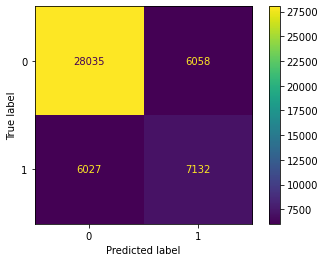

In [28]:
#These were the best hyper paramaters from the model tunings that I ran
xg_clf = xgb.XGBClassifier(
 colsample_bytree = 0.8058016898686793,
 gamma= 1.3625777342639867,
 learning_rate= 0.10458356577582398,
 max_delta_step= 2,
 max_depth= 20,
 min_child_weight= 64.30336808953497,
 n_estimators= 26,
 objective= 'binary:logistic',
 scale_pos_weight= 2,
 subsample= 0.9616607533615821,
 enable_categorical = True,
 tree_method = "hist")

xg_clf.fit(X, y)
xg_predict = xg_clf.predict(X_validation)
print_F1_score(y_validation, xg_predict)
ConfusionMatrixDisplay.from_predictions(y_validation, xg_predict)
plt.show()

F1 Score is: 0.743


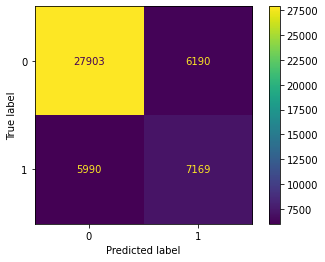

In [29]:
X, X_validation, y, y_validation = split_data(model_df_dummy)

xg_clf = xgb.XGBClassifier(
 colsample_bytree = 0.8058016898686793,
 gamma= 1.3625777342639867,
 learning_rate= 0.10458356577582398,
 max_delta_step= 2,
 max_depth= 20,
 min_child_weight= 64.30336808953497,
 n_estimators= 26,
 objective= 'binary:logistic',
 scale_pos_weight= 2,
 subsample= 0.9616607533615821)

# training the model
xg_clf.fit(X, y)

xg_predict = xg_clf.predict(X_validation)
print_F1_score(y_validation, xg_predict)
ConfusionMatrixDisplay.from_predictions(y_validation, xg_predict)
plt.show()

In [30]:
top_features = get_top_features(X, xg_clf).reset_index()
top_features.head(20)
top_features.head(20)["index"].tolist()

['LEGAL_YN',
 'PAYMENT_METHOD_NonDD',
 'PAYMENT_METHOD_PureDD',
 'P1_MAR_STATUS_P',
 'quote_variation_unknown',
 'CONTENTS_COVER_N',
 'HP3_NY',
 'KEYCARE_NY',
 'HP3_NN',
 'LEGAL_NY',
 'AD_BUILDINGS_N',
 'HP1_NY',
 'HP1_NN',
 'MAX_DAYS_UNOCC',
 'NCD_GRANTED_YEARS_B_7.0',
 'AD_BUILDINGS_Y',
 'LEGAL_NN',
 'OCC_STATUS_LP',
 'HOME_EM_YN',
 'LEGAL_YY']

In [31]:
#Shap method
explainer = shap.Explainer(xg_clf)
shap_values = explainer(X, check_additivity=False)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


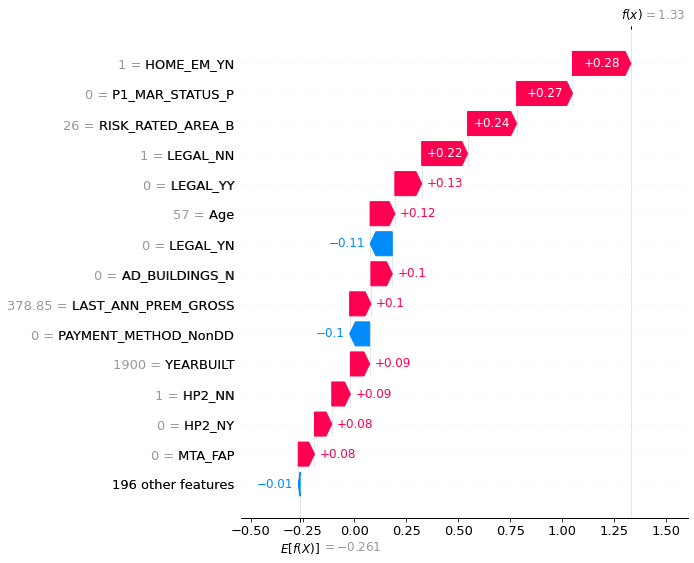

In [32]:
shap.plots.waterfall(shap_values[666], max_display=15)

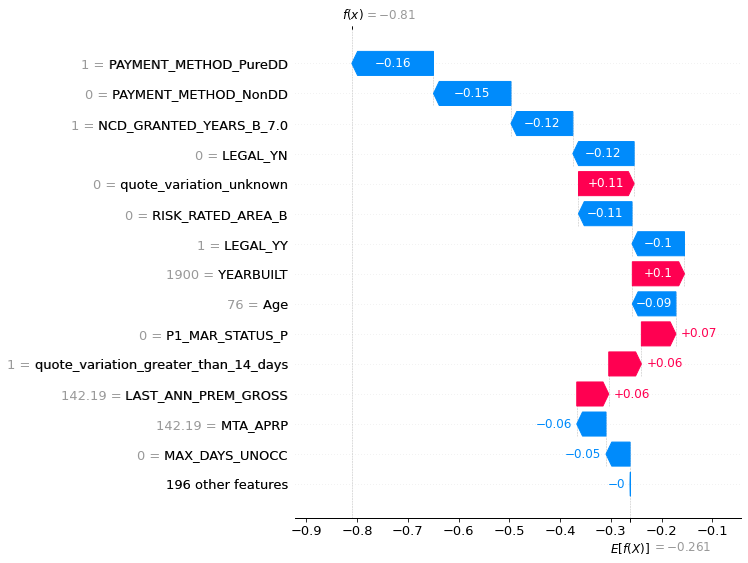

In [33]:
shap.plots.waterfall(shap_values[333], max_display=15)

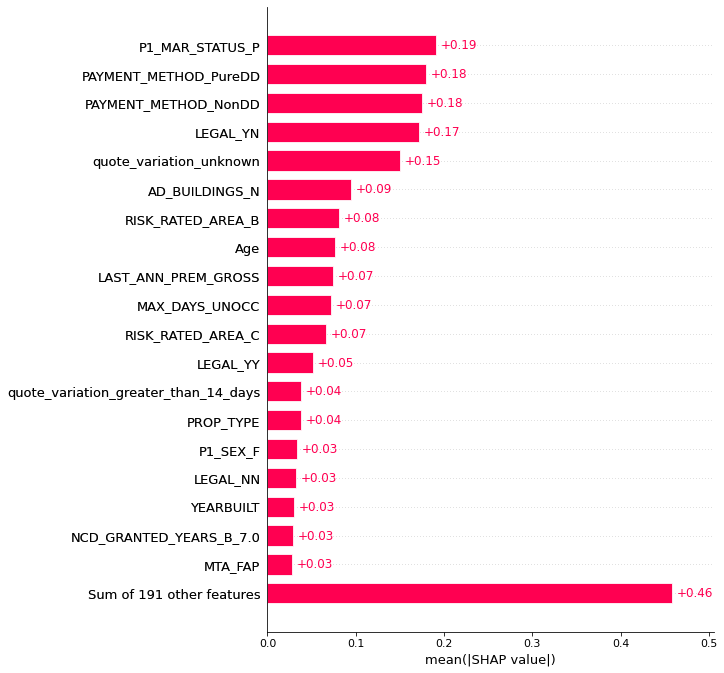

In [34]:
shap.plots.bar(shap_values, max_display = 20)